In [1]:
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import LSTM, Dropout, RepeatVector, TimeDistributed, Dense
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns

In [2]:
# 시퀀스 데이터 생성 함수
def to_sequences(x, seq_size=1):
    x_values = []
    for i in range(len(x)-seq_size):
        x_values.append(x.iloc[i:(i+seq_size)].values)
    return np.array(x_values)


In [3]:
# sns.lineplot(x=df['Date'], y=df['brake_value'])

In [4]:
# sns.lineplot(x=df['Date'], y=df['shift_speed'])

In [5]:
# sns.lineplot(x=df['Date'], y=df['accel_value'])

In [6]:
dataframe = pd.read_csv('C:\\Users\\jinho\\Desktop\\Taba_AI\\dataset\\0510_brake.csv')

# 이전 값을 빼고 min max scaling
dataframe['shift_speed'] = dataframe['speed'] - dataframe['speed'].shift(1)
dataframe['shift_speed'].fillna(0, inplace = True)

# target 값으로 shift_speed를 한 칸씩 뒤로 밀린 값 사용
dataframe['target_shift_speed'] = dataframe['shift_speed'].shift(-1)
dataframe['target_shift_speed'].fillna(0, inplace=True)

min_shift_speed = min(dataframe['shift_speed'])
max_shift_speed = max(dataframe['shift_speed'])

normalization_speed_df = (dataframe['shift_speed'] - min_shift_speed) / (max_shift_speed - min_shift_speed)

dataframe['normalize_speed'] = normalization_speed_df
dataframe.head()

C:\Users\jinho\AppData\Local\Temp\ipykernel_8008\2018450019.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  dataframe['shift_speed'].fillna(0, inplace = True)
C:\Users\jinho\AppData\Local\Temp\ipykernel_8008\2018450019.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For exa

,brake_value,accel_value,speed,Date,shift_speed,target_shift_speed,normalize_speed
0,0,335,0,2024-05-10 07:27:34.730321+00:00,0.0,0.0,0.393939
1,6,374,0,2024-05-10 07:27:35.768378+00:00,0.0,0.0,0.393939
2,0,345,0,2024-05-10 07:27:36.788696+00:00,0.0,2.0,0.393939
3,0,256,2,2024-05-10 07:27:37.809518+00:00,2.0,5.0,0.454545
4,0,371,7,2024-05-10 07:27:38.772035+00:00,5.0,0.0,0.545455


In [7]:
df = dataframe[['accel_value', 'brake_value', 'shift_speed',  'target_shift_speed', 'Date']]

count = df['accel_value'].count()
train = df.iloc[:int(count*0.8)]
test = df.iloc[int(count*0.8):]

# 데이터 정규화
scaler = MinMaxScaler()
scaler = scaler.fit(train[['accel_value', 'brake_value']])

train[['accel_value','brake_value']] = scaler.transform(train[['accel_value','brake_value']])
test[['accel_value','brake_value']] = scaler.transform(test[['accel_value','brake_value']])
# 속도 값은 정규화하지 않음
train['shift_speed'] = train['shift_speed']
train['target_shift_speed'] = train['target_shift_speed']
test['shift_speed'] = test['shift_speed'] 
test['target_shift_speed'] = test['target_shift_speed']

C:\Users\jinho\AppData\Local\Temp\ipykernel_8008\3957500042.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[['accel_value','brake_value']] = scaler.transform(train[['accel_value','brake_value']])
C:\Users\jinho\AppData\Local\Temp\ipykernel_8008\3957500042.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[['accel_value','brake_value']] = scaler.transform(test[['accel_value','brake_value']])
C:\Users\jinho\AppData\Local\Temp\ipykernel_8008\3957500042.py:14: SettingWithCopyWarning: 
A value 

C:\Users\jinho\anaconda3\envs\ml\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 3, 128)              │          67,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 119,105 (465.25 KB)

 Trainable params: 119,105 (465.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 63ms/step - loss: 1.0009 - val_loss: 0.8236
Epoch 2/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1.0047 - val_loss: 0.8123
Epoch 3/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.9476 - val_loss: 0.7998
Epoch 4/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.9105 - val_loss: 0.7846
Epoch 5/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.8355 - val_loss: 0.7454
Epoch 6/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.8533 - val_loss: 0.7189
Epoch 7/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.7755 - val_loss: 0.6988
Epoch 8/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.7719 - val_loss: 0.6782
Epoch 9/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.7340 - val_loss: 0.6670
Epoch 10/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.7360 - val_loss: 0.6554
Epoch 11/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.7243 - val_loss: 0.6453
Epoch 12/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.7

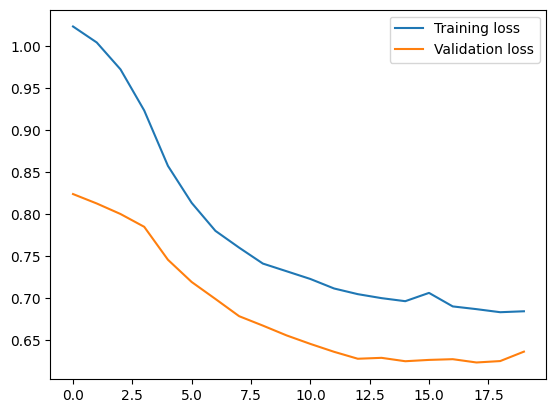

In [8]:
seq_size = 3  # Number of time steps to look back

trainX = to_sequences(train[['accel_value', 'brake_value', 'shift_speed']], seq_size)
testX = to_sequences(test[['accel_value', 'brake_value', 'shift_speed']], seq_size)

# 예측 값은 시퀀스의 마지막 값으로 설정
trainY = train[['target_shift_speed']].iloc[seq_size:].values
testY = test[['target_shift_speed']].iloc[seq_size:].values

# 모델 정의
model = Sequential()
model.add(LSTM(128, input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
# LSTM 레이어를 추가하고, 입력 크기는 (시퀀스 길이, 입력 특성 수)로 설정합니다.
# return_sequences=True로 설정하여 각 시점의 출력을 모두 반환하도록 합니다.

model.add(LSTM(64))
# 두 번째 LSTM 레이어를 추가하며, 이번에는 시퀀스 출력을 사용하지 않습니다.

model.add(Dense(32, activation='relu'))
# 완전 연결 레이어를 추가하여 LSTM 출력을 더 복잡한 특성으로 변환합니다.

model.add(Dense(trainY.shape[1]))
# 최종 출력 레이어를 추가하여 target_shift_speed를 예측합니다.

model.compile(optimizer='adam', loss='mae')
model.summary()

# 모델 학습
history = model.fit(trainX, trainY, epochs=20, batch_size=128, validation_split=0.1, verbose=1)

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [ ]:
# seq_size = 3  # Number of time steps to look back

# trainX = to_sequences(train[['accel_value', 'brake_value']], seq_size)
# testX = to_sequences(test[['accel_value', 'brake_value']], seq_size)

# # 예측 값은 시퀀스의 마지막 값으로 설정
# trainY = train[['shift_speed']].iloc[seq_size:].values
# testY = test[['shift_speed']].iloc[seq_size:].values

In [ ]:
# # 모델 정의
# model = Sequential()
# model.add(LSTM(128, input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
# # LSTM 레이어를 추가하고, 입력 크기는 (시퀀스 길이, 입력 특성 수)로 설정합니다.
# # return_sequences=True로 설정하여 각 시점의 출력을 모두 반환하도록 합니다.

# model.add(LSTM(64))
# # 두 번째 LSTM 레이어를 추가하며, 이번에는 시퀀스 출력을 사용하지 않습니다.

# model.add(Dense(32, activation='relu'))
# # 완전 연결 레이어를 추가하여 LSTM 출력을 더 복잡한 특성으로 변환합니다.

# model.add(Dense(trainY.shape[1]))
# # 최종 출력 레이어를 추가하여 target_shift_speed를 예측합니다.

# model.compile(optimizer='adam', loss='mae')
# model.summary()


C:\Users\jinho\anaconda3\envs\ml\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                        │ (None, 128)                 │          67,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 67,713 (264.50 KB)

 Trainable params: 67,713 (264.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - loss: 1.0223 - val_loss: 0.8446
Epoch 2/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.0184 - val_loss: 0.8318
Epoch 3/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.0098 - val_loss: 0.8236
Epoch 4/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 1.0245 - val_loss: 0.8104
Epoch 5/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.9731 - val_loss: 0.8068
Epoch 6/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.8551 - val_loss: 0.8244
Epoch 7/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.8999 - val_loss: 0.8258
Epoch 8/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.8110 - val_loss: 0.8026
Epoch 9/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.7659 - val_loss: 0.7937
Epoch 10/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.8027 - val_loss: 0.7785
Epoch 11/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.8102 - val_loss: 0.7782
Epoch 12/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.8

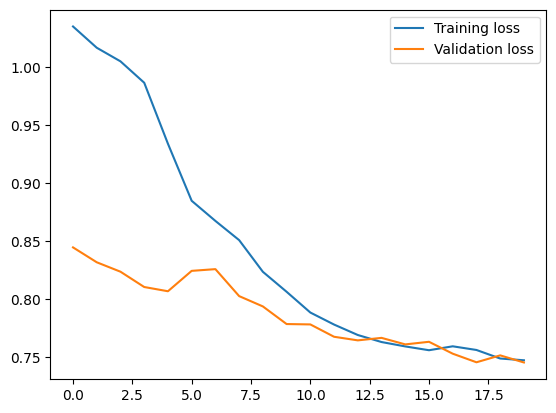

In [31]:
# 모델 학습
history = model.fit(trainX, trainY, epochs=20, batch_size=128, validation_split=0.1, verbose=1)

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [58]:
# from keras.metrics import MeanAbsoluteError
# # 사용자 정의 메트릭을 custom_objects로 제공
# model = keras.models.load_model(
#     'C:\\Users\\jinho\\Desktop\\Taba_AI\\taba_model.h5',
#     custom_objects={'mae': MeanAbsoluteError()}
# )

# print(model.summary())

In [66]:
sample = np.expand_dims(testX[0], axis=0)
# 예측
prediction = model.predict(sample)
testMAE = np.mean(np.abs(prediction - testY[0]), axis=1)
print(testMAE)
print("y:", testY[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
[2.95978239]
y: [3.]


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
[4.6081233]


77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


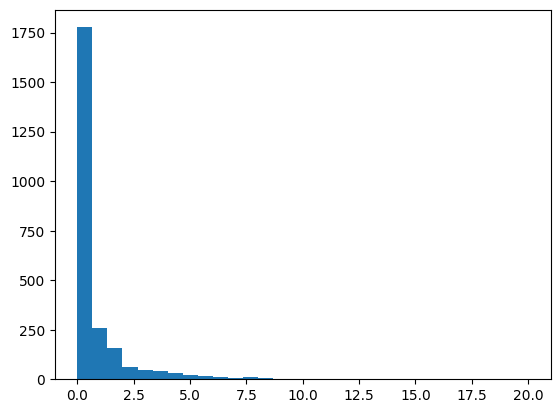

20.011829314753413
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


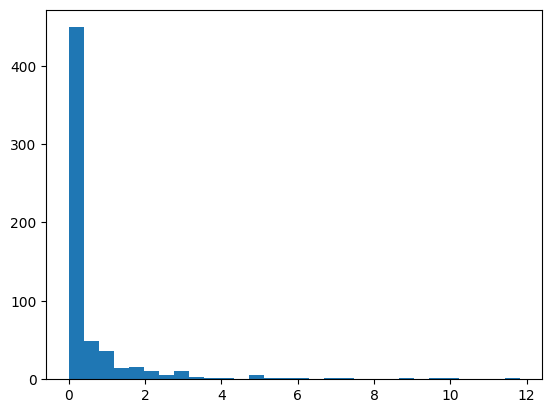

In [67]:
# 모델 평가 및 이상치 탐지
trainPredict = model.predict(trainX)
# trainY와 예측값의 차이 계산
trainMAE = np.mean(np.abs(trainPredict - trainY), axis=1)
plt.hist(trainMAE, bins=30)
plt.show()
print(max(trainMAE))
# trainMAE = 0.4252552301949038

max_trainMAE = max(trainMAE) * 0.8  # 또는 최대값의 90%를 임계값으로 정의.
testPredict = model.predict(testX)
# testY와 예측값의 차이 계산
testMAE = np.mean(np.abs(testPredict - testY), axis=1)
plt.hist(testMAE, bins=30)
plt.show()

In [68]:
# Capture all details in a DataFrame for easy plotting
# anomaly_df = pd.DataFrame(test[seq_size:])
# anomaly_df['testMAE'] = testMAE
# anomaly_df['max_trainMAE'] = max_trainMAE
# anomaly_df['anomaly'] = anomaly_df['testMAE'] > anomaly_df['max_trainMAE']
# anomaly_df[['shift_speed', 'accel_value', 'brake_value']] = test[seq_size:][['shift_speed', 'accel_value', 'brake_value']]

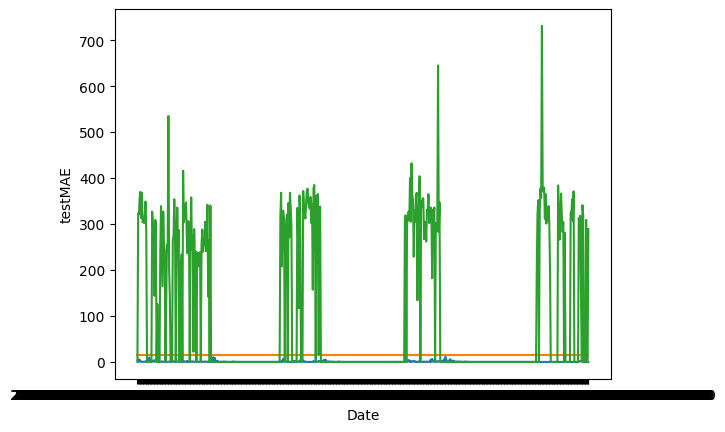

In [69]:
# Plot testMAE vs max_trainMAE
sns.lineplot(x=anomaly_df['Date'], y=anomaly_df['testMAE'])
sns.lineplot(x=anomaly_df['Date'], y=anomaly_df['max_trainMAE'])

anomalies = anomaly_df.loc[anomaly_df['anomaly'] == True]


# Plot anomalies
sns.lineplot(x=anomaly_df['Date'], y=scaler.inverse_transform(anomaly_df[['accel_value', 'brake_value']])[:, 0])

if not anomalies.empty:
    sns.scatterplot(x=anomalies['Date'], y=scaler.inverse_transform(anomalies[['accel_value', 'brake_value']])[:, 0], color='r')

In [9]:
model.save("AI_revise_3.h5")